**Q1-Part-A**

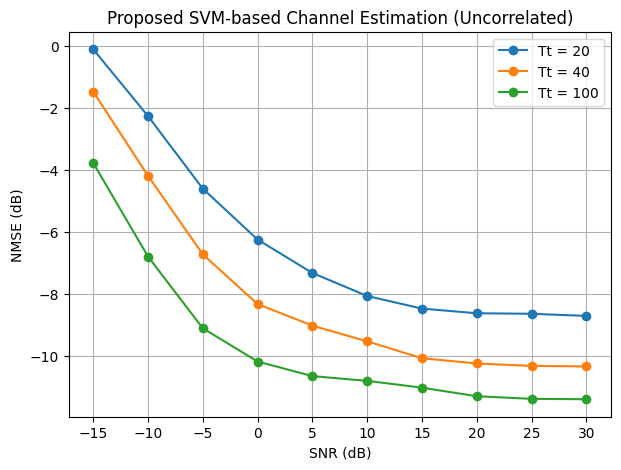

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

# System parameters (paper)

K = 4
N = 32
Tt_list = [20, 40, 100]
SNRdB = np.arange(-15, 31, 5)
MC = 200
C = 1.0

NMSE = np.zeros((len(Tt_list), len(SNRdB)))

# Main loop
for tt, Tt in enumerate(Tt_list):

    # DFT-based pilots (same as paper)
    F = np.fft.fft(np.eye(Tt))
    Xt_bar = F[1:K+1, :]                 # K × Tt

    # Real-domain pilot matrix (Eq. 11)
    Xt = np.block([
        [ np.real(Xt_bar),  np.imag(Xt_bar)],
        [-np.imag(Xt_bar),  np.real(Xt_bar)]
    ])                                   # 2K × 2Tt

    Xt = Xt.T                            # samples × features

    for s, snr_db in enumerate(SNRdB):
        rho = 10**(snr_db / 10)
        N0 = 1 / rho

        mse_sum = 0.0

        for _ in range(MC):

            # Channel CN(0,1)
            H = (np.random.randn(N, K) + 1j*np.random.randn(N, K)) / np.sqrt(2)

            # Noise
            Z = np.sqrt(N0/2) * (np.random.randn(N, Tt) + 1j*np.random.randn(N, Tt))

            # Quantized received pilots
            Y = H @ Xt_bar + Z
            def hard_sign(x):
                return np.where(x >= 0, 1.0, -1.0)

            Yq = hard_sign(np.real(Y)) + 1j*hard_sign(np.imag(Y))

            # Real-domain received signal
            Yt = np.hstack([np.real(Yq), np.imag(Yq)])  # N × 2Tt

            Hhat = np.zeros((N, 2*K))

            # SVM per antenna (Eq. 13)
            for i in range(N):
                y = Yt[i, :]

                svm = LinearSVC(
                C=1.0 * (2*Tt),
                loss='squared_hinge',
                fit_intercept=False,
                max_iter=5000
            )


                svm.fit(Xt, y)
                h_tilde = svm.coef_.flatten()

                # Eq. (14) normalization
                Hhat[i, :] = np.sqrt(K) * h_tilde / np.linalg.norm(h_tilde)

            # Back to complex domain
            Hhat_c = Hhat[:, :K] + 1j*Hhat[:, K:]

            mse_sum += np.linalg.norm(Hhat_c - H, 'fro')**2 / (K*N)

        NMSE[tt, s] = mse_sum / MC

# Plot
plt.figure(figsize=(7,5))
for tt, Tt in enumerate(Tt_list):
    plt.plot(SNRdB, 10*np.log10(NMSE[tt]), marker='o', label=f'Tt = {Tt}')

plt.xlabel('SNR (dB)')
plt.ylabel('NMSE (dB)')
plt.grid(True)
plt.legend()
plt.title('Proposed SVM-based Channel Estimation (Uncorrelated)')
plt.xticks(np.arange(-15, 31, 5))
plt.show()


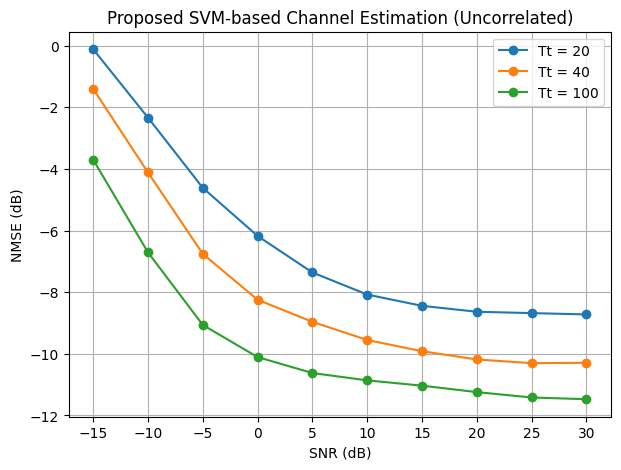

In [ ]:
plt.figure(figsize=(7,5))
for tt, Tt in enumerate(Tt_list):
    plt.plot(SNRdB, 10*np.log10(NMSE[tt]), marker='o', label=f'Tt = {Tt}')

plt.xlabel('SNR (dB)')
plt.ylabel('NMSE (dB)')
plt.grid(True)
plt.legend()
plt.title('Proposed SVM-based Channel Estimation (Uncorrelated)')

plt.xticks(np.arange(-15, 31, 5))   # <<< 5 dB spacing
plt.show()


**Q1-Part-B**

Simulating Fig 6 with L2-Norm SVM (Corrected)
N=32, K=4, Tt=20, Iterations=300
SNR: -15 dB, NMSE: -1.9210 dB
SNR: -10 dB, NMSE: -5.0254 dB
SNR: -5 dB, NMSE: -8.0540 dB
SNR: 0 dB, NMSE: -10.5088 dB
SNR: 5 dB, NMSE: -11.9626 dB
SNR: 10 dB, NMSE: -12.3659 dB
SNR: 15 dB, NMSE: -12.5386 dB
SNR: 20 dB, NMSE: -12.3991 dB
SNR: 25 dB, NMSE: -12.4380 dB
SNR: 30 dB, NMSE: -12.4334 dB


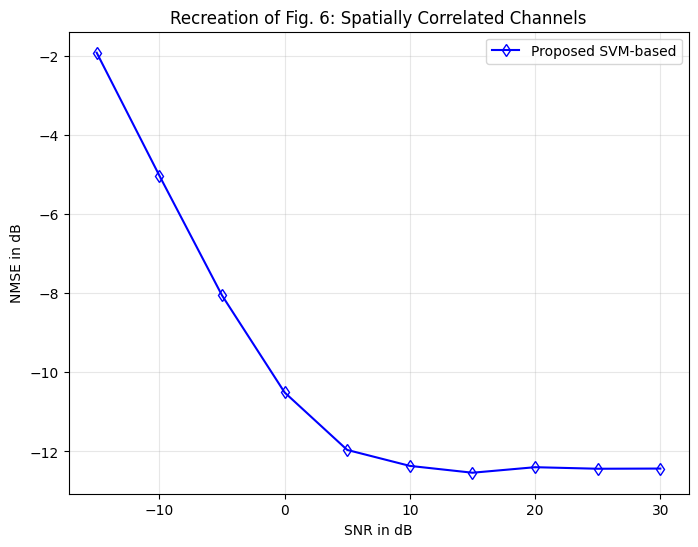

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import dft

def generate_spatial_correlation_matrix(N, angle_spread_deg, aoa_deg):
    R = np.zeros((N, N), dtype=complex)
    distance_norm = 0.5 # d/lambda

    # Laplacian PAS approximation parameters
    num_paths = 1000
    sigma = np.deg2rad(angle_spread_deg)
    theta_0 = np.deg2rad(aoa_deg)

    # Generate paths
    u = np.random.uniform(-0.5, 0.5, num_paths)
    thetas = theta_0 - (sigma / np.sqrt(2)) * np.sign(u) * np.log(1 - 2 * np.abs(u))

    # Sum of outer products of steering vectors
    for theta in thetas:
        array_idx = np.arange(N)
        a = np.exp(-1j * 2 * np.pi * distance_norm * array_idx * np.sin(theta))
        a = a.reshape(-1, 1)
        R += a @ a.conj().T

    return R / num_paths

def run_simulation_figure_6_l2_norm():
    N = 32              # BS antennas
    K = 4               # Users
    Tt = 20             # Pilot length
    C_svm_param = 1.0   # SVM C parameter

    # SNR range matches x-axis of Figure 6
    snr_db_range = np.array([-15, -10, -5, 0, 5, 10, 15, 20, 25, 30])

    num_monte_carlo = 300

    # Pilot Generation
    F = dft(Tt, scale=None)
    X_pilots_complex = F[:, 1:K+1].T

    X_real = np.real(X_pilots_complex)
    X_imag = np.imag(X_pilots_complex)

    # Xt block structure: (Eq. 11)
    Xt = np.vstack([
        np.hstack([X_real, X_imag]),
        np.hstack([-X_imag, X_real])
    ])

    # Covariance Matrix Generation
    angle_spread = 10
    aoas = np.linspace(-60, 60, K)

    Ck_matrices_complex = []
    Ck_inv_matrices_real = []

    for k in range(K):
        R = generate_spatial_correlation_matrix(N, angle_spread, aoas[k])
        Ck_matrices_complex.append(R)

        # Real domain expansion for SVM formulation
        R_real = np.real(R)
        R_imag = np.imag(R)
        Ck_real_domain = np.vstack([
            np.hstack([R_real, -R_imag]),
            np.hstack([R_imag, R_real])
        ])

        # Add jitter for numerical stability during inversion
        Ck_real_domain += 1e-6 * np.eye(2*N)


        inv_Ck = np.linalg.inv(Ck_real_domain)
        inv_Ck = (inv_Ck + inv_Ck.T) / 2
        Ck_inv_matrices_real.append(inv_Ck)

    # Normalization factor: E[||H||_F] = sqrt(KN)
    norm_factor_scale = np.sqrt(K * N)

    nmse_results = []

    print(f"Simulating Fig 6 with L2-Norm SVM (Corrected)")
    print(f"N={N}, K={K}, Tt={Tt}, Iterations={num_monte_carlo}")

    for snr_db in snr_db_range:
        nmse_accum = 0.0
        snr_linear = 10**(snr_db / 10.0)
        n0 = 1.0 / snr_linear

        for mc in range(num_monte_carlo):
            # Channel Realization
            H_complex = np.zeros((N, K), dtype=complex)
            for k in range(K):
                # Generate spatially correlated channel vector
                h_iid = (np.random.randn(N) + 1j * np.random.randn(N)) / np.sqrt(2)

                # Correlation coloring: h = C^(1/2) * h_iid
                try:
                    L = np.linalg.cholesky(Ck_matrices_complex[k])
                except np.linalg.LinAlgError:
                    u, s, vh = np.linalg.svd(Ck_matrices_complex[k])
                    L = u @ np.diag(np.sqrt(s))

                H_complex[:, k] = L @ h_iid

            # Received Signal
            # r = Hx + z
            Z = np.sqrt(n0/2) * (np.random.randn(N, Tt) + 1j * np.random.randn(N, Tt))
            R_val = H_complex @ X_pilots_complex + Z

            # 1-bit Quantization: y = sign(r)
            Y_complex = np.sign(np.real(R_val)) + 1j * np.sign(np.imag(R_val))

            # Construct Yt for SVM input (Eq. 8)
            Yt = np.hstack([np.real(Y_complex), np.imag(Y_complex)])

            # SVM Optimization (Eq. 20 with L2-Norm)
            # Variable: H_var represents columns [Re(hk); Im(hk)]
            H_var = cp.Variable((2*N, K))

            # Objective Term 1: Mahalanobis Distance (Regularization)
            obj_term_1 = 0
            for k in range(K):
                # Use psd_wrap to ensure CVXPY accepts the matrix as PSD
                obj_term_1 += 0.5 * cp.quad_form(H_var[:, k], cp.psd_wrap(Ck_inv_matrices_real[k]))

            # Constraints Preparation
            H_re = H_var[:N, :]
            H_im = H_var[N:, :]
            H_t_matrix = cp.hstack([H_re, H_im])
            P = H_t_matrix @ Xt # Linear prediction

            Slacks = cp.Variable((N, 2*Tt), nonneg=True)

            # Sign Constraints
            constraints = [
                cp.multiply(Yt, P) >= 1 - Slacks
            ]

            # Objective Term 2: L2-Norm Penalty
            obj_term_2 = C_svm_param * cp.sum_squares(Slacks)

            prob = cp.Problem(cp.Minimize(obj_term_1 + obj_term_2), constraints)
            prob.solve(solver=cp.OSQP, eps_abs=1e-4, eps_rel=1e-4, verbose=False)

            if H_var.value is None:
                H_hat_final = np.zeros((N, K), dtype=complex)
            else:
                H_hat_re = H_re.value
                H_hat_im = H_im.value
                H_hat_complex = H_hat_re + 1j * H_hat_im

                # Normalization
                fro_norm = np.linalg.norm(H_hat_complex, 'fro')
                if fro_norm > 0:
                    H_hat_final = norm_factor_scale * H_hat_complex / fro_norm
                else:
                    H_hat_final = H_hat_complex

            # NMSE Calculation
            error = np.linalg.norm(H_complex - H_hat_final, 'fro')**2
            nmse_accum += error / (K * N)

        avg_nmse = nmse_accum / num_monte_carlo
        nmse_db = 10 * np.log10(avg_nmse)
        nmse_results.append(nmse_db)
        print(f"SNR: {snr_db} dB, NMSE: {nmse_db:.4f} dB")

    # --- Plot ---
    plt.figure(figsize=(8, 6))
    plt.plot(snr_db_range, nmse_results, 'd-', color='blue', mfc='none', label='Proposed SVM-based')
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.xlabel('SNR in dB')
    plt.ylabel('NMSE in dB')
    plt.title('Recreation of Fig. 6: Spatially Correlated Channels')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    run_simulation_figure_6_l2_norm()

**Q2 and 3**

Simulating SVM-based OFDM Channel Estimation (Fig 12)
Nc=256, K=2, L_tap=8, Antennas=16
SNR: -15 dB, NMSE: -1.1819 dB
SNR: -10 dB, NMSE: -4.0695 dB
SNR: -5 dB, NMSE: -7.4484 dB
SNR: 0 dB, NMSE: -10.4821 dB
SNR: 5 dB, NMSE: -12.6528 dB
SNR: 10 dB, NMSE: -14.3025 dB
SNR: 15 dB, NMSE: -15.2642 dB
SNR: 20 dB, NMSE: -15.8890 dB
SNR: 25 dB, NMSE: -16.0391 dB
SNR: 30 dB, NMSE: -16.1916 dB


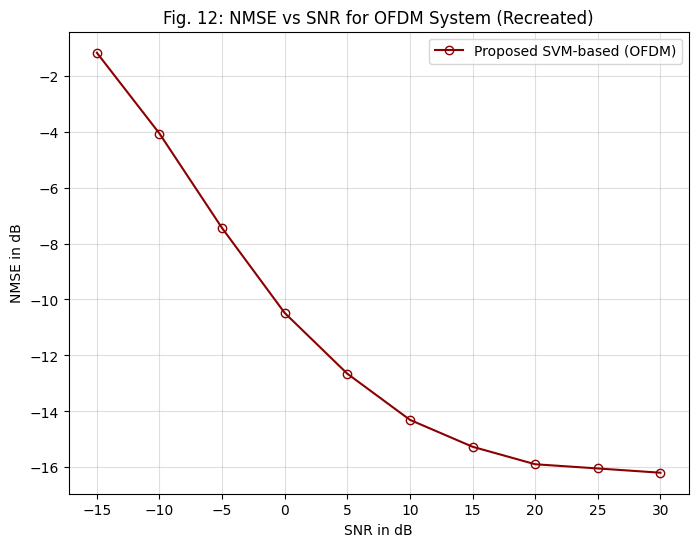

In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import dft, toeplitz

def create_circulant_matrix_first_L_cols(pilot_td, L_tap):
    Nc = len(pilot_td)
    Phi = np.zeros((Nc, L_tap), dtype=complex)
    for l in range(L_tap):
        Phi[:, l] = np.roll(pilot_td, l)

    return Phi

def run_simulation_figure_12():
    Nc = 256            # Number of subcarriers
    K = 2               # Number of users
    N = 16              # Number of BS antennas
    L_tap = 8           # Number of channel taps
    C_svm_param = 1.0   # SVM regularization

    # SNR range for Figure 12
    snr_db_range = np.array([-15, -10, -5, 0, 5, 10, 15, 20, 25, 30])

    # Monte Carlo Iterations
    num_monte_carlo = 150

    # Pilot Generation
    X_pilots_FD = np.zeros((Nc, K), dtype=complex)

    # User 1 (Indices 0, 2, 4...)
    idx_u1 = np.arange(0, Nc, 2)
    syms_u1 = (2 * np.random.randint(0, 2, len(idx_u1)) - 1) + \
              1j * (2 * np.random.randint(0, 2, len(idx_u1)) - 1)
    X_pilots_FD[idx_u1, 0] = syms_u1

    # User 2 (Indices 1, 3, 5...)
    idx_u2 = np.arange(1, Nc, 2)
    syms_u2 = (2 * np.random.randint(0, 2, len(idx_u2)) - 1) + \
              1j * (2 * np.random.randint(0, 2, len(idx_u2)) - 1)
    X_pilots_FD[idx_u2, 1] = syms_u2

    # Convert to Time Domain: phi_k^TD = F^H * x_k^FD
    Phi_pilots_TD = np.fft.ifft(X_pilots_FD, axis=0) * np.sqrt(Nc) # Normalize to preserve energy

    # Construct Training Matrix Phi_L^TD (Eq. 42)
    Phi_list = []
    for k in range(K):
        Phi_k = create_circulant_matrix_first_L_cols(Phi_pilots_TD[:, k], L_tap)
        Phi_list.append(Phi_k)

    # This is the complex training matrix (Nc x K*L_tap)
    Phi_train_complex = np.hstack(Phi_list)

    # Convert to Real Domain for SVM (Eq. 42)
    # Phi_real = [Re(Phi) -Im(Phi); Im(Phi) Re(Phi)]
    Phi_re = np.real(Phi_train_complex)
    Phi_im = np.imag(Phi_train_complex)

    Phi_train_real = np.vstack([
        np.hstack([Phi_re, -Phi_im]),
        np.hstack([Phi_im, Phi_re])
    ])

    nmse_results = []

    print(f"Simulating SVM-based OFDM Channel Estimation (Fig 12)")
    print(f"Nc={Nc}, K={K}, L_tap={L_tap}, Antennas={N}")

    for snr_db in snr_db_range:
        nmse_accum = 0.0
        snr_linear = 10**(snr_db / 10.0)
        n0 = 1.0 / snr_linear

        for mc in range(num_monte_carlo):
            # Channel Generation
            H_taps_complex = np.sqrt(1.0 / (2 * L_tap)) * \
                             (np.random.randn(K * L_tap, N) + 1j * np.random.randn(K * L_tap, N))

            # Received Signal Generation
            # y_i = sign(Phi_train * h_i + z_i)
            Z_noise = np.sqrt(n0 / 2) * \
                      (np.random.randn(Nc, N) + 1j * np.random.randn(Nc, N))

            # Unquantized signal (Nc x N)
            Y_unquantized = Phi_train_complex @ H_taps_complex + Z_noise

            # 1-bit Quantization
            Y_quantized_complex = np.sign(np.real(Y_unquantized)) + \
                                  1j * np.sign(np.imag(Y_unquantized))

            # SVM Estimation per Antenna
            H_hat_all = np.zeros_like(H_taps_complex)

            for i in range(N):
                # Prepare Real-domain vectors for antenna i
                # y_i^TD = [Re(y_i); Im(y_i)] (Size 2*Nc)
                y_i_complex = Y_quantized_complex[:, i]
                y_i_real = np.concatenate([np.real(y_i_complex), np.imag(y_i_complex)])

                # SVM Optimization Variable: h_i^TD (Size 2*K*L_tap)
                # h_i^TD = [Re(h); Im(h)]
                dim_h = 2 * K * L_tap
                h_var = cp.Variable(dim_h)
                slacks = cp.Variable(2 * Nc, nonneg=True)

                # Constraints: y_n * (h^T * phi_n) >= 1 - xi_n
                constraint_expr = cp.multiply(y_i_real, Phi_train_real @ h_var)

                prob_constraints = [constraint_expr >= 1 - slacks]

                # Objective: 0.5||h||^2 + C * sum(l(xi))
                obj = 0.5 * cp.sum_squares(h_var) + C_svm_param * cp.sum_squares(slacks)
                problem = cp.Problem(cp.Minimize(obj), prob_constraints)

                # Solve
                try:
                    problem.solve(solver=cp.OSQP, eps_abs=1e-3, eps_rel=1e-3, verbose=False)
                except:
                    problem.solve(solver=cp.SCS, verbose=False)

                if h_var.value is not None:
                    h_val_real = h_var.value
                    # Reconstruct complex vector
                    # h = [Re; Im]
                    mid = len(h_val_real) // 2
                    h_hat_i = h_val_real[:mid] + 1j * h_val_real[mid:]

                    # Normalization
                    # hat_h = sqrt(K) * h / ||h||
                    norm_h = np.linalg.norm(h_hat_i)
                    if norm_h > 0:
                        h_hat_i = np.sqrt(K) * h_hat_i / norm_h

                    H_hat_all[:, i] = h_hat_i

            # NMSE Calculation
            # NMSE = E[||H - H_hat||^2] / E[||H||^2]
            error = np.linalg.norm(H_taps_complex - H_hat_all, 'fro')**2

            # Normalization factor used in paper's definition:
            # NMSE = E[error] / (KN)
            nmse_accum += error / (K * N)

        avg_nmse = nmse_accum / num_monte_carlo
        nmse_db = 10 * np.log10(avg_nmse)
        nmse_results.append(nmse_db)
        print(f"SNR: {snr_db} dB, NMSE: {nmse_db:.4f} dB")

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(snr_db_range, nmse_results, 'o-', color='darkred', mfc='none', label='Proposed SVM-based (OFDM)')
    plt.xlabel('SNR in dB')
    plt.ylabel('NMSE in dB')
    plt.title('Fig. 12: NMSE vs SNR for OFDM System (Recreated)')
    plt.grid(True, which="both", ls="-", alpha=0.4)
    plt.legend()
    plt.xticks(np.arange(-15, 31, 5))
    plt.show()

if __name__ == "__main__":
    run_simulation_figure_12()


**Q4**

--- Simulating Part 1(a): Uncorrelated Channels ---
1(a) SNR -15dB: Base=-0.16, Corr=-0.11
1(a) SNR -10dB: Base=-2.31, Corr=-2.29
1(a) SNR -5dB: Base=-4.57, Corr=-4.57
1(a) SNR 0dB: Base=-6.15, Corr=-6.25
1(a) SNR 5dB: Base=-7.23, Corr=-7.24
1(a) SNR 10dB: Base=-8.00, Corr=-8.00
1(a) SNR 15dB: Base=-8.47, Corr=-8.54
1(a) SNR 20dB: Base=-8.61, Corr=-8.64
1(a) SNR 25dB: Base=-8.75, Corr=-8.79
1(a) SNR 30dB: Base=-8.71, Corr=-8.71


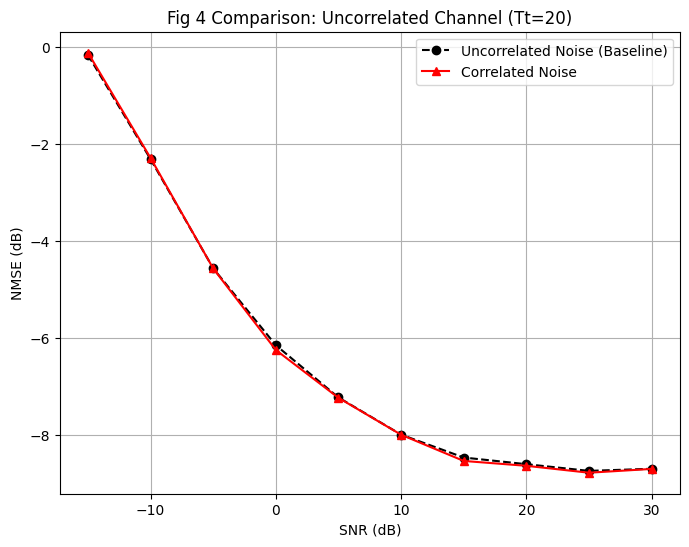


--- Simulating Part 1(b): Correlated Channels ---
1(b) SNR -15dB: Base=-2.04, Corr=-1.94
1(b) SNR -10dB: Base=-5.07, Corr=-4.92
1(b) SNR -5dB: Base=-8.05, Corr=-8.10
1(b) SNR 0dB: Base=-10.47, Corr=-10.49
1(b) SNR 5dB: Base=-11.82, Corr=-11.82
1(b) SNR 10dB: Base=-12.27, Corr=-12.22
1(b) SNR 15dB: Base=-12.68, Corr=-12.63
1(b) SNR 20dB: Base=-12.14, Corr=-12.05
1(b) SNR 25dB: Base=-12.45, Corr=-12.39
1(b) SNR 30dB: Base=-12.34, Corr=-12.35


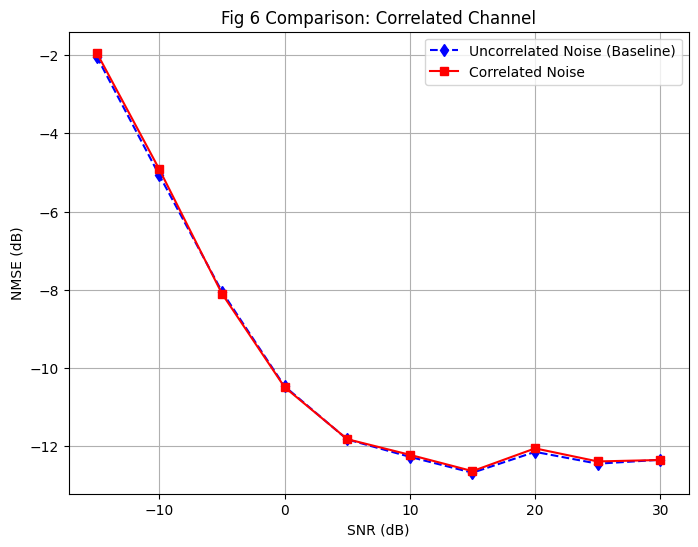

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.svm import LinearSVC
from scipy.linalg import dft, toeplitz

# ==========================================
# Uncorrelated Channels
# ==========================================
def run_fig4_comparison():
    print("--- Simulating Part 1(a): Uncorrelated Channels ---")

    # System Parameters
    K = 4
    N = 32
    Tt = 20  # Fixed Tt for this comparison to keep plot clean
    SNRdB = np.arange(-15, 31, 5)
    MC = 100

    # Noise Correlation Matrix (Exponential Model)
    rho_noise = 0.7
    col = rho_noise ** np.arange(N)
    R_noise = toeplitz(col)
    # Cholesky decomposition for coloring
    try:
        L_noise = np.linalg.cholesky(R_noise)
    except:
        U, S, Vh = np.linalg.svd(R_noise)
        L_noise = U @ np.diag(np.sqrt(S))

    # Pilot Setup
    F = np.fft.fft(np.eye(Tt))
    Xt_bar = F[1:K+1, :]
    Xt = np.block([
        [np.real(Xt_bar), np.imag(Xt_bar)],
        [-np.imag(Xt_bar), np.real(Xt_bar)]
    ]).T # Samples x Features

    nmse_baseline = np.zeros(len(SNRdB))
    nmse_corr_noise = np.zeros(len(SNRdB))

    for s, snr_db in enumerate(SNRdB):
        rho = 10**(snr_db / 10)
        N0 = 1 / rho

        mse_base = 0.0
        mse_corr = 0.0

        for _ in range(MC):
            # Channel
            H = (np.random.randn(N, K) + 1j*np.random.randn(N, K)) / np.sqrt(2)

            # Case 1: Uncorrelated Noise (Baseline)
            Z_iid = np.sqrt(N0/2) * (np.random.randn(N, Tt) + 1j*np.random.randn(N, Tt))
            Y_base = H @ Xt_bar + Z_iid

            # Case 2: Correlated Noise
            # Z_corr = L * Z_iid (Normalized so power is same)
            Z_unit = (np.random.randn(N, Tt) + 1j*np.random.randn(N, Tt)) / np.sqrt(2)
            Z_c = np.sqrt(N0) * (L_noise @ Z_unit)
            Y_corr = H @ Xt_bar + Z_c

            # Function to process SVM for a given Y
            def solve_svm(Y_input):
                def hard_sign(x): return np.where(x >= 0, 1.0, -1.0)
                Yq = hard_sign(np.real(Y_input)) + 1j*hard_sign(np.imag(Y_input))
                Yt = np.hstack([np.real(Yq), np.imag(Yq)])

                Hhat = np.zeros((N, 2*K))
                for i in range(N):
                    svm = LinearSVC(C=1.0*(2*Tt), loss='squared_hinge', fit_intercept=False, max_iter=1000, dual="auto")
                    svm.fit(Xt, Yt[i, :])
                    h_val = svm.coef_.flatten()
                    norm_h = np.linalg.norm(h_val)
                    if norm_h > 0:
                        Hhat[i, :] = np.sqrt(K) * h_val / norm_h
                return Hhat[:, :K] + 1j*Hhat[:, K:]

            # Solve for both
            H_base = solve_svm(Y_base)
            H_corr = solve_svm(Y_corr)

            mse_base += np.linalg.norm(H_base - H, 'fro')**2 / (K*N)
            mse_corr += np.linalg.norm(H_corr - H, 'fro')**2 / (K*N)

        nmse_baseline[s] = 10*np.log10(mse_base / MC)
        nmse_corr_noise[s] = 10*np.log10(mse_corr / MC)
        print(f"1(a) SNR {snr_db}dB: Base={nmse_baseline[s]:.2f}, Corr={nmse_corr_noise[s]:.2f}")

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(SNRdB, nmse_baseline, 'k--o', label='Uncorrelated Noise (Baseline)')
    plt.plot(SNRdB, nmse_corr_noise, 'r-^', label='Correlated Noise')
    plt.xlabel('SNR (dB)')
    plt.ylabel('NMSE (dB)')
    plt.title('Fig 4 Comparison: Uncorrelated Channel (Tt=20)')
    plt.legend()
    plt.grid(True)
    plt.show()

# ==========================================
# Correlated Channels
# ==========================================
def generate_spatial_correlation_matrix(N, angle_spread_deg, aoa_deg):
    R = np.zeros((N, N), dtype=complex)
    distance_norm = 0.5
    num_paths = 1000
    sigma = np.deg2rad(angle_spread_deg)
    theta_0 = np.deg2rad(aoa_deg)
    u = np.random.uniform(-0.5, 0.5, num_paths)
    thetas = theta_0 - (sigma / np.sqrt(2)) * np.sign(u) * np.log(1 - 2 * np.abs(u))
    for theta in thetas:
        array_idx = np.arange(N)
        a = np.exp(-1j * 2 * np.pi * distance_norm * array_idx * np.sin(theta))
        a = a.reshape(-1, 1)
        R += a @ a.conj().T
    return R / num_paths

def run_fig6_comparison():
    print("\n--- Simulating Part 1(b): Correlated Channels ---")

    N, K, Tt = 32, 4, 20
    SNRdB = np.arange(-15, 31, 5)
    MC = 50 # Reduced for execution speed
    C_svm = 1.0

    # Noise Correlation
    rho_noise = 0.7
    col = rho_noise ** np.arange(N)
    R_noise = toeplitz(col)
    U, S, Vh = np.linalg.svd(R_noise)
    L_noise = U @ np.diag(np.sqrt(S))

    # Channel Covariances
    aoas = np.linspace(-60, 60, K)
    Ck_mats = []
    Ck_inv_real = []
    for k in range(K):
        R = generate_spatial_correlation_matrix(N, 10, aoas[k])
        Ck_mats.append(R)
        # Real domain inverse for SVM
        R_real = np.real(R)
        R_imag = np.imag(R)
        Ck_r = np.vstack([np.hstack([R_real, -R_imag]), np.hstack([R_imag, R_real])]) + 1e-6*np.eye(2*N)
        inv_C = np.linalg.inv(Ck_r)
        inv_C = (inv_C + inv_C.T)/2
        Ck_inv_real.append(inv_C)

    # Pilots
    F = dft(Tt, scale=None)
    X_pil = F[:, 1:K+1].T
    Xr = np.real(X_pil); Xi = np.imag(X_pil)
    Xt = np.vstack([np.hstack([Xr, Xi]), np.hstack([-Xi, Xr])])

    norm_factor = np.sqrt(K*N)
    nmse_base_res = []
    nmse_corr_res = []

    for snr_db in SNRdB:
        n0 = 10**(-snr_db/10.0)
        mse_base = 0.0
        mse_corr = 0.0

        for _ in range(MC):
            # Generate Channel
            H_c = np.zeros((N, K), dtype=complex)
            for k in range(K):
                h_iid = (np.random.randn(N) + 1j*np.random.randn(N))/np.sqrt(2)
                u, s, vh = np.linalg.svd(Ck_mats[k])
                L = u @ np.diag(np.sqrt(s))
                H_c[:, k] = L @ h_iid

            # Baseline Noise (IID)
            Z_unit = (np.random.randn(N, Tt) + 1j*np.random.randn(N, Tt))/np.sqrt(2)
            Z_base = np.sqrt(n0) * Z_unit

            # Correlated Noise
            Z_corr = np.sqrt(n0) * (L_noise @ Z_unit)

            # Solvers
            def solve_cvx_svm(Y_recv):
                Y_q = np.sign(np.real(Y_recv)) + 1j*np.sign(np.imag(Y_recv))
                Yt = np.hstack([np.real(Y_q), np.imag(Y_q)])

                H_var = cp.Variable((2*N, K))
                obj1 = 0
                for k in range(K):
                    obj1 += 0.5 * cp.quad_form(H_var[:, k], cp.psd_wrap(Ck_inv_real[k]))

                H_re = H_var[:N, :]; H_im = H_var[N:, :]
                P = cp.hstack([H_re, H_im]) @ Xt
                Slacks = cp.Variable((N, 2*Tt), nonneg=True)
                con = [cp.multiply(Yt, P) >= 1 - Slacks]
                obj2 = C_svm * cp.sum_squares(Slacks)

                prob = cp.Problem(cp.Minimize(obj1 + obj2), con)
                prob.solve(solver=cp.OSQP, eps_abs=1e-3, eps_rel=1e-3, verbose=False)

                if H_var.value is None: return np.zeros((N, K), dtype=complex)

                H_res = H_re.value + 1j*H_im.value
                fn = np.linalg.norm(H_res, 'fro')
                return norm_factor * H_res / fn if fn > 0 else H_res

            H_hat_base = solve_cvx_svm(H_c @ X_pil + Z_base)
            H_hat_corr = solve_cvx_svm(H_c @ X_pil + Z_corr)

            mse_base += np.linalg.norm(H_c - H_hat_base, 'fro')**2 / (K*N)
            mse_corr += np.linalg.norm(H_c - H_hat_corr, 'fro')**2 / (K*N)

        nmse_base_res.append(10*np.log10(mse_base/MC))
        nmse_corr_res.append(10*np.log10(mse_corr/MC))
        print(f"1(b) SNR {snr_db}dB: Base={nmse_base_res[-1]:.2f}, Corr={nmse_corr_res[-1]:.2f}")

    plt.figure(figsize=(8, 6))
    plt.plot(SNRdB, nmse_base_res, 'b--d', label='Uncorrelated Noise (Baseline)')
    plt.plot(SNRdB, nmse_corr_res, 'r-s', label='Correlated Noise')
    plt.xlabel('SNR (dB)')
    plt.ylabel('NMSE (dB)')
    plt.title('Fig 6 Comparison: Correlated Channel')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    run_fig4_comparison()
    run_fig6_comparison()